<a href="https://colab.research.google.com/github/AlexJurcich/energy-consumption-pattern-discovery/blob/main/energy_consumption_pattern_discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Energy Consumption Pattern Discovery**

## Alex Jurcich

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from tqdm import tqdm
from google.colab import drive
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

## Import Data

In [ ]:
drive.mount('/content/drive')
drive_root = "/content/drive/MyDrive/Data Mining Data"
os.makedirs("/content/apartment_elec", exist_ok=True)
os.makedirs("/content/apartment_weather", exist_ok=True)

# Extract electrical data
!tar -xzf "{drive_root}/apartment-electrical.tar.gz" -C "/content/apartment_elec"

# Extract weather data
!tar -xzf "{drive_root}/apartment-weather.tar.gz" -C "/content/apartment_weather"

# Quick check of folder contents
!ls -R /content/apartment_elec
!ls -R /content/apartment_weather

Mounted at /content/drive
/content/apartment_elec:
apartment

/content/apartment_elec/apartment:
2014  2015  2016

/content/apartment_elec/apartment/2014:
Apt100_2014.csv  Apt50_2014.csv      summary_Apt104.txt  summary_Apt51.txt
Apt101_2014.csv  Apt51_2014.csv      summary_Apt105.txt  summary_Apt52.txt
Apt10_2014.csv	 Apt5_2014.csv	     summary_Apt106.txt  summary_Apt53.txt
Apt102_2014.csv  Apt52_2014.csv      summary_Apt107.txt  summary_Apt54.txt
Apt103_2014.csv  Apt53_2014.csv      summary_Apt108.txt  summary_Apt55.txt
Apt104_2014.csv  Apt54_2014.csv      summary_Apt109.txt  summary_Apt56.txt
Apt105_2014.csv  Apt55_2014.csv      summary_Apt10.txt	 summary_Apt57.txt
Apt106_2014.csv  Apt56_2014.csv      summary_Apt110.txt  summary_Apt58.txt
Apt107_2014.csv  Apt57_2014.csv      summary_Apt111.txt  summary_Apt59.txt
Apt108_2014.csv  Apt58_2014.csv      summary_Apt112.txt  summary_Apt5.txt
Apt109_2014.csv  Apt59_2014.csv      summary_Apt113.txt  summary_Apt60.txt
Apt110_2014.csv  Apt60_2

In [ ]:
import pandas as pd

# Look at one apartment file
sample_elec = pd.read_csv(
    "/content/apartment_elec/apartment/2014/Apt1_2014.csv",
    header=None
)

print(sample_elec.head())
print(sample_elec.shape)
print(sample_elec.columns)
sample_elec.head()

                     0    1
0  2014-10-15 12:00:00  0.0
1  2014-10-15 12:15:00  0.0
2  2014-10-15 12:30:00  0.0
3  2014-10-15 12:45:00  0.0
4  2014-10-15 13:00:00  0.0
(7444, 2)
Index([0, 1], dtype='int64')


,0,1
0,2014-10-15 12:00:00,0.0
1,2014-10-15 12:15:00,0.0
2,2014-10-15 12:30:00,0.0
3,2014-10-15 12:45:00,0.0
4,2014-10-15 13:00:00,0.0


In [ ]:
sample_weather = pd.read_csv("/content/apartment_weather/apartment-weather/apartment2014.csv")
print(sample_weather.shape)
print(sample_weather.columns)
sample_weather.head()


(8784, 14)
Index(['temperature', 'icon', 'humidity', 'visibility', 'summary',
       'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover', 'time',
       'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability'],
      dtype='object')


,temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability
0,19.76,clear-night,0.48,10.0,Clear,7.42,1020.07,11.96,0.0,1388552400,280,0.0,3.42,0.0
1,18.74,clear-night,0.49,10.0,Clear,7.44,1024.01,9.78,0.0,1388556000,280,0.0,2.58,0.0
2,17.40,clear-night,0.53,10.0,Clear,7.74,1024.97,7.19,0.0,1388559600,252,0.0,3.15,0.0
3,16.94,clear-night,0.54,10.0,Clear,7.00,1025.83,7.40,0.0,1388563200,244,0.0,3.37,0.0
4,15.51,clear-night,0.60,10.0,Clear,7.16,1026.00,5.47,0.0,1388566800,225,0.0,4.11,0.0


### Set Column Names

In [ ]:
sample_elec.columns = ['timestamp', 'power']
sample_elec['timestamp'] = pd.to_datetime(sample_elec['timestamp'])
sample_elec.head()

,timestamp,power
0,2014-10-15 12:00:00,0.0
1,2014-10-15 12:15:00,0.0
2,2014-10-15 12:30:00,0.0
3,2014-10-15 12:45:00,0.0
4,2014-10-15 13:00:00,0.0


In [ ]:
sample_weather['timestamp'] = pd.to_datetime(sample_weather['time'], unit = 's')
sample_weather.head()

,temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability,timestamp
0,19.76,clear-night,0.48,10.0,Clear,7.42,1020.07,11.96,0.0,1388552400,280,0.0,3.42,0.0,2014-01-01 05:00:00
1,18.74,clear-night,0.49,10.0,Clear,7.44,1024.01,9.78,0.0,1388556000,280,0.0,2.58,0.0,2014-01-01 06:00:00
2,17.40,clear-night,0.53,10.0,Clear,7.74,1024.97,7.19,0.0,1388559600,252,0.0,3.15,0.0,2014-01-01 07:00:00
3,16.94,clear-night,0.54,10.0,Clear,7.00,1025.83,7.40,0.0,1388563200,244,0.0,3.37,0.0,2014-01-01 08:00:00
4,15.51,clear-night,0.60,10.0,Clear,7.16,1026.00,5.47,0.0,1388566800,225,0.0,4.11,0.0,2014-01-01 09:00:00


### Merge Data

Chatgbt hwlped with this code

In [ ]:
ELEC_TS_COL = "timestamp"
POWER_COL = "power"

years = [2014, 2015, 2016]
daily_elec_list = []

for year in years:
    pattern = f"/content/apartment_elec/apartment/{year}/Apt*_{year}.csv"
    files = sorted(glob.glob(pattern))
    print(f"Year {year}: found {len(files)} apartment files")

    for fpath in tqdm(files):
        apt_id = os.path.basename(fpath).split("_")[0]  # e.g., Apt1

        # Load data
        df = pd.read_csv(fpath, header=None)
        df.columns = [ELEC_TS_COL, POWER_COL]

        # Fix timestamp
        df[ELEC_TS_COL] = pd.to_datetime(df[ELEC_TS_COL], errors="coerce")
        df = df.dropna(subset=[ELEC_TS_COL])

        # Extract date + hour
        df["date"] = df[ELEC_TS_COL].dt.date
        df["hour"] = df[ELEC_TS_COL].dt.hour

        # Daily summary
        daily = df.groupby("date").agg(
            mean_power  = (POWER_COL, "mean"),
            max_power   = (POWER_COL, "max"),
            min_power   = (POWER_COL, "min"),
            std_power   = (POWER_COL, "std"),
            total_power = (POWER_COL, "sum")
        ).reset_index()

        # Peak hour
        peak_hour_series = df.groupby(["date", "hour"])[POWER_COL].mean().reset_index()
        peak_hour = peak_hour_series.loc[peak_hour_series.groupby("date")[POWER_COL].idxmax()]
        peak_hour = peak_hour.set_index("date")["hour"]
        daily["peak_hour"] = daily["date"].map(peak_hour)

        # Add apartment/year information
        daily["apt_id"] = apt_id
        daily["year"] = year

        daily_elec_list.append(daily)

daily_elec = pd.concat(daily_elec_list, ignore_index=True)
daily_elec["date"] = pd.to_datetime(daily_elec["date"])

print("Electrical daily dataset:", daily_elec.shape)
daily_elec.head()


Year 2014: found 108 apartment files


100%|██████████| 108/108 [00:03<00:00, 33.33it/s]


Year 2015: found 114 apartment files


100%|██████████| 114/114 [00:13<00:00,  8.15it/s]


Year 2016: found 114 apartment files


100%|██████████| 114/114 [01:50<00:00,  1.03it/s]

Electrical daily dataset: (90348, 9)


,date,mean_power,max_power,min_power,std_power,total_power,peak_hour,apt_id,year
0,2014-10-15,0.0,0.0,0.0,0.0,0.0,10,Apt100,2014
1,2014-10-16,0.0,0.0,0.0,0.0,0.0,0,Apt100,2014
2,2014-10-17,0.0,0.0,0.0,0.0,0.0,0,Apt100,2014
3,2014-10-18,0.0,0.0,0.0,0.0,0.0,0,Apt100,2014
4,2014-10-19,0.0,0.0,0.0,0.0,0.0,0,Apt100,2014


In [ ]:
daily_weather_list = []

for year in years:
    wpath = f"/content/apartment_weather/apartment-weather/apartment{year}.csv"
    wdf = pd.read_csv(wpath)

    # Convert UNIX timestamp to datetime
    wdf["timestamp"] = pd.to_datetime(wdf["time"], unit="s")
    wdf["date"] = wdf["timestamp"].dt.date

    # Some weather files do not include all columns; fill missing ones
    expected_cols = [
        "temperature", "humidity", "dewPoint", "cloudCover",
        "windSpeed", "visibility", "pressure", "apparentTemperature"
    ]
    for col in expected_cols:
        if col not in wdf.columns:
            wdf[col] = None  # create missing column

    # Daily aggregation
    daily_w = wdf.groupby("date").agg(
        mean_temp          = ("temperature", "mean"),
        max_temp           = ("temperature", "max"),
        min_temp           = ("temperature", "min"),
        mean_humidity      = ("humidity", "mean"),
        mean_dew_point     = ("dewPoint", "mean"),
        mean_cloud_cover   = ("cloudCover", "mean"),
        mean_wind_speed    = ("windSpeed", "mean"),
        mean_visibility    = ("visibility", "mean"),
        mean_pressure      = ("pressure", "mean"),
        mean_apparent_temp = ("apparentTemperature", "mean")
    ).reset_index()

    daily_w["year"] = year
    daily_weather_list.append(daily_w)

# Combine weather across years
daily_weather = pd.concat(daily_weather_list, ignore_index=True)
daily_weather["date"] = pd.to_datetime(daily_weather["date"])

print("Weather daily dataset:", daily_weather.shape)
daily_weather.head()

Weather daily dataset: (1101, 12)


,date,mean_temp,max_temp,min_temp,mean_humidity,mean_dew_point,mean_cloud_cover,mean_wind_speed,mean_visibility,mean_pressure,mean_apparent_temp,year
0,2014-01-01,19.863684,25.35,14.47,0.531053,5.239474,0.010000,7.328947,9.961579,1027.251579,10.843684,2014
1,2014-01-02,15.299167,19.50,8.96,0.785833,9.760833,0.306667,7.087917,3.680833,1024.785417,6.342083,2014
2,2014-01-03,5.393333,9.22,2.75,0.683750,-3.064167,0.170000,12.559583,4.501250,1015.581667,-10.993750,2014
3,2014-01-04,2.294167,22.92,-10.49,0.617917,-8.778750,0.001667,5.470833,9.789583,1030.989167,-4.697500,2014
4,2014-01-05,18.110000,32.66,3.37,0.668750,8.574583,0.008095,4.045833,9.298750,1026.205417,13.850000,2014


In [ ]:
daily_all = daily_elec.merge(
    daily_weather,
    on=["date", "year"],
    how="left"
)

print("Merged dataset:", daily_all.shape)
daily_all.head()

data = daily_all.copy()

Merged dataset: (90348, 19)


## EDA

### Remove instances where power = 0

In [ ]:
data = data[data['total_power'] > 0]

### Describe the Data

In [ ]:
data.describe()

,date,mean_power,max_power,min_power,std_power,total_power,peak_hour,year,mean_temp,max_temp,min_temp,mean_humidity,mean_dew_point,mean_cloud_cover,mean_wind_speed,mean_visibility,mean_pressure,mean_apparent_temp
count,88303,8.830300e+04,88303.000000,88303.000000,88303.000000,88303.000000,88303.000000,88303.000000,88303.000000,88303.000000,88303.000000,88303.000000,88303.000000,88303.000000,88303.000000,88303.000000,88303.000000,88303.000000
mean,2015-11-24 11:21:06.887874816,1.194194e+00,6.136667,0.161722,1.097532,818.232193,12.689240,2015.375197,49.058671,58.866443,40.473649,0.675360,37.597169,0.184583,6.510090,9.101146,1017.278977,46.386323
min,2014-08-14 00:00:00,1.282115e-07,0.000007,0.000000,0.000000,0.000007,0.000000,2014.000000,-4.165417,7.760000,-13.050000,0.316250,-22.220000,0.004583,2.014583,2.264583,992.108333,-22.198750
25%,2015-05-15 00:00:00,4.773903e-01,4.491589,0.014767,0.696031,89.208982,8.000000,2015.000000,34.710417,41.930000,28.120000,0.587083,23.946250,0.068750,4.387500,8.772917,1012.418333,29.770000
50%,2015-11-25 00:00:00,1.008175e+00,6.041667,0.033800,1.117195,217.029932,12.000000,2015.000000,49.545000,59.910000,40.890000,0.685000,37.897917,0.136667,6.028750,9.645833,1017.090833,48.427917
75%,2016-06-06 00:00:00,1.796301e+00,7.948650,0.152220,1.483202,1277.419758,19.000000,2016.000000,66.316667,77.050000,55.290000,0.767083,54.372083,0.226250,8.220000,9.949167,1021.977917,66.316667
max,2016-12-28 00:00:00,1.047114e+01,927.495739,5.414588,94.594270,7188.202467,23.000000,2016.000000,80.208750,93.780000,74.390000,0.960417,72.485000,1.000000,18.638333,10.000000,1043.114167,83.298333
std,NaN,9.086154e-01,5.349619,0.332892,0.696352,1089.256296,6.532352,0.624106,18.471254,19.656011,18.068868,0.125336,19.219592,0.183364,2.767863,1.266892,7.391137,21.528485


### Data info

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88303 entries, 5 to 90347
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                88303 non-null  datetime64[ns]
 1   mean_power          88303 non-null  float64       
 2   max_power           88303 non-null  float64       
 3   min_power           88303 non-null  float64       
 4   std_power           88303 non-null  float64       
 5   total_power         88303 non-null  float64       
 6   peak_hour           88303 non-null  int32         
 7   apt_id              88303 non-null  object        
 8   year                88303 non-null  int64         
 9   mean_temp           88303 non-null  float64       
 10  max_temp            88303 non-null  float64       
 11  min_temp            88303 non-null  float64       
 12  mean_humidity       88303 non-null  float64       
 13  mean_dew_point      88303 non-null  float64       


### Distributions

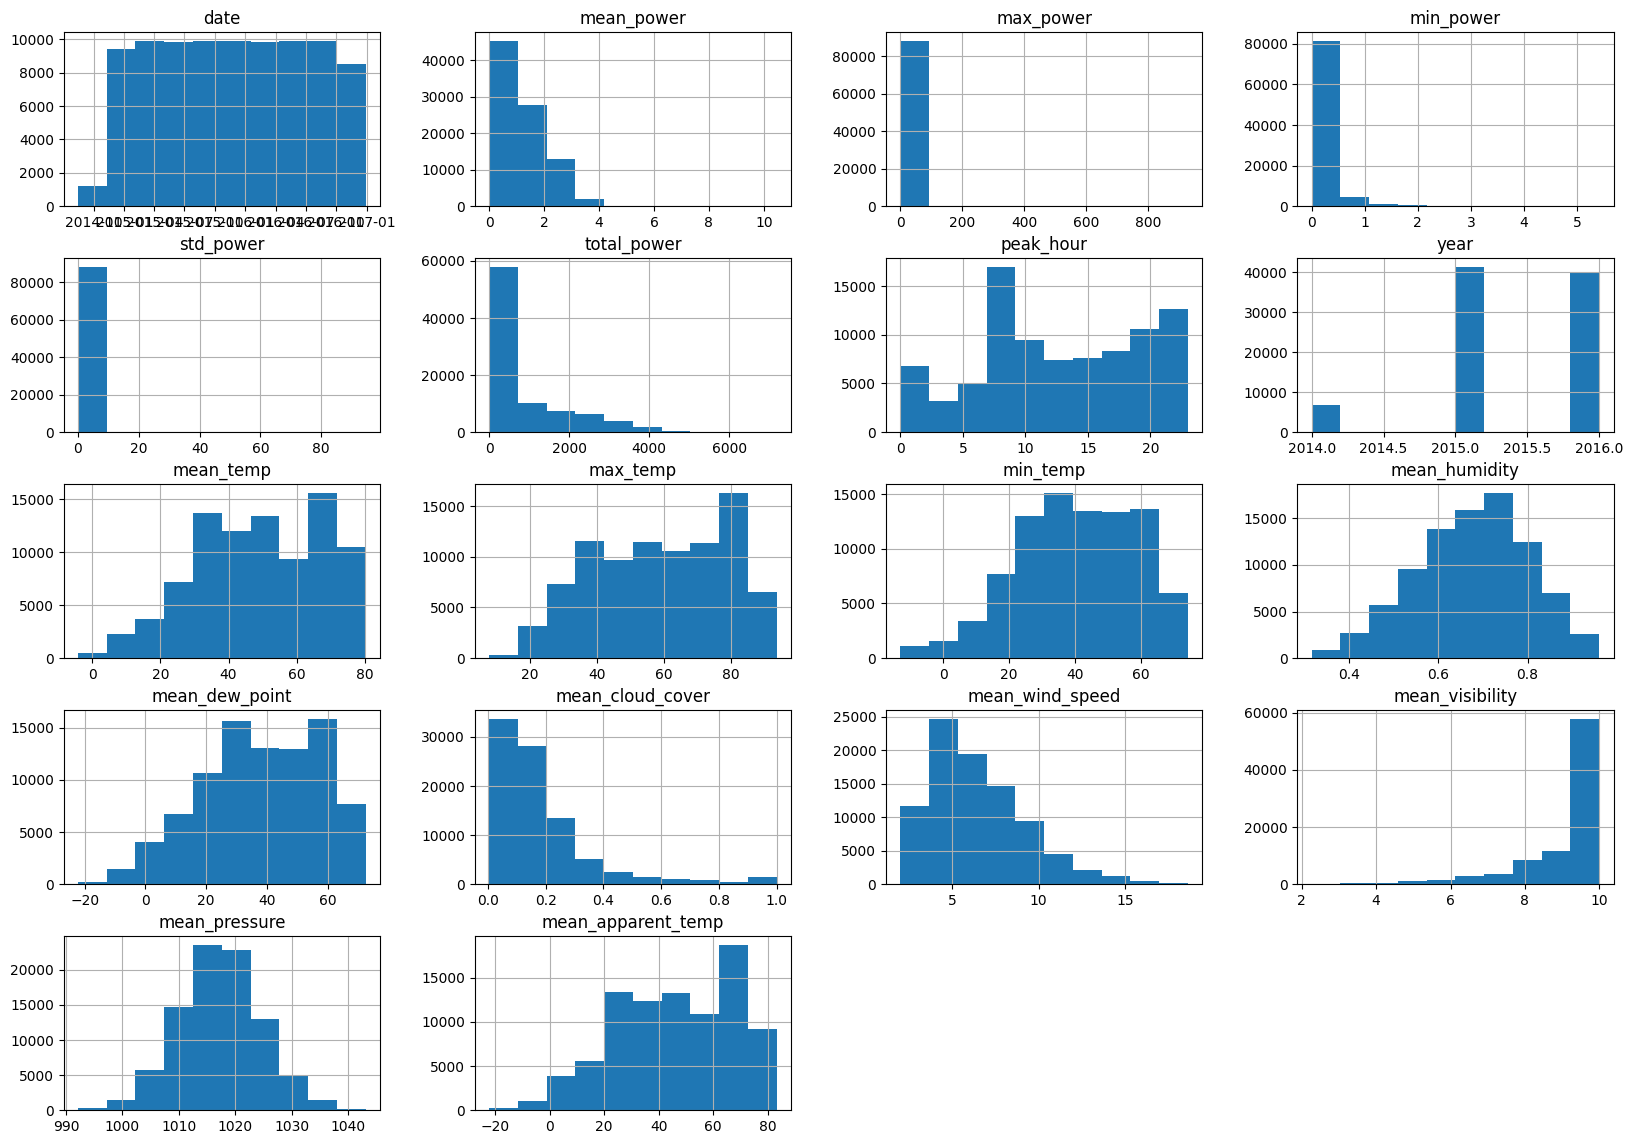

In [ ]:
%matplotlib inline
data.hist(figsize=(20, 14))
plt.show()

### Define the Seasons & Day of the week

In [ ]:
# Day of week: Monday=0, Sunday=6
data["day_of_week"] = data["date"].dt.dayofweek

# Weekend flag
data["is_weekend"] = (data["day_of_week"] >= 5).astype(int)

# Month
data["month"] = data["date"].dt.month

# Simple season mapping
def get_season(m):
    if m in [12, 1, 2]:
        return "winter"
    elif m in [3, 4, 5]:
        return "spring"
    elif m in [6, 7, 8]:
        return "summer"
    else:
        return "fall"

data["season"] = data["month"].apply(get_season)

data[["date", "apt_id", "total_power", "day_of_week", "is_weekend", "month", "season"]].head()

,date,apt_id,total_power,day_of_week,is_weekend,month,season
5,2014-10-20,Apt100,0.514106,0,0,10,fall
7,2014-10-22,Apt100,0.000588,2,0,10,fall
8,2014-10-23,Apt100,0.001600,3,0,10,fall
9,2014-10-24,Apt100,0.001600,4,0,10,fall
10,2014-10-25,Apt100,0.001600,5,1,10,fall


In [ ]:
print(data[["season"]].value_counts())
print(data[["day_of_week"]].value_counts().sort_index())
print(data[["is_weekend"]].value_counts())

season
fall      24211
winter    22104
summer    21012
spring    20976
Name: count, dtype: int64
day_of_week
0              12633
1              12633
2              12662
3              12667
4              12564
5              12573
6              12571
Name: count, dtype: int64
is_weekend
0             63159
1             25144
Name: count, dtype: int64


### Check for Outliers

In [ ]:
# Look at extreme total_power days
data[['date', 'season', 'mean_temp' ,'apt_id','total_power']].sort_values(by='total_power', ascending=False)

,date,season,mean_temp,apt_id,total_power
52864,2016-02-14,winter,-4.165417,Apt107,7188.202467
78117,2016-02-15,winter,1.463333,Apt69,6847.408283
57064,2016-02-14,winter,-4.165417,Apt14,6623.713267
77734,2016-01-13,winter,23.845833,Apt68,6559.259483
68978,2016-02-15,winter,1.463333,Apt45,6557.852950
...,...,...,...,...,...
3668,2014-10-25,fall,50.319583,Apt39,0.000054
7794,2014-10-25,fall,50.319583,Apt87,0.000047
8357,2014-11-03,fall,40.614167,Apt93,0.000030
1029,2014-10-30,fall,46.002917,Apt111,0.000021


### Remove Outliers

In [ ]:
features = ["total_power", "mean_power", "max_power", "min_power", "std_power"]

def remove_iqr_outliers(df, columns, k=1.5):
    df_clean = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - k * IQR
        upper = Q3 + k * IQR

        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

    return df_clean

data_iqr = remove_iqr_outliers(data, features)

print("Before:", data.shape)
print("After:", data_iqr.shape)

Before: (88303, 23)
After: (69603, 23)


In [ ]:
data_new = data_iqr.copy()

# PCA

In [ ]:
data_new.head()

,date,mean_power,max_power,min_power,std_power,total_power,peak_hour,apt_id,year,mean_temp,...,mean_dew_point,mean_cloud_cover,mean_wind_speed,mean_visibility,mean_pressure,mean_apparent_temp,day_of_week,is_weekend,month,season
5,2014-10-20,0.005355,0.514106,0.000000,0.052471,0.514106,13,Apt100,2014,42.109167,...,29.178333,0.103750,6.355000,9.992917,1017.406667,39.428333,0,0,10,fall
7,2014-10-22,0.000006,0.000017,0.000000,0.000008,0.000588,16,Apt100,2014,51.431667,...,46.977917,1.000000,10.931250,8.107083,1016.407500,50.947917,2,0,10,fall
8,2014-10-23,0.000017,0.000017,0.000017,0.000000,0.001600,0,Apt100,2014,48.882500,...,45.508333,1.000000,13.320833,7.141250,1008.851250,44.840000,3,0,10,fall
9,2014-10-24,0.000017,0.000017,0.000017,0.000000,0.001600,0,Apt100,2014,48.810000,...,43.350833,0.937500,9.245417,9.339583,1008.374583,45.592917,4,0,10,fall
10,2014-10-25,0.000017,0.000017,0.000017,0.000000,0.001600,0,Apt100,2014,50.319583,...,40.235000,0.050417,6.146667,9.410833,1008.250833,48.724583,5,1,10,fall


In [ ]:
# One-hot encode season
season_dummies = pd.get_dummies(data_new["season"], prefix="season")

# Build full feature matrix
X = pd.concat([
    data_new[[
        "mean_power", "max_power", "min_power", "std_power", "total_power",
        "mean_temp", "max_temp", "min_temp", "mean_humidity", "is_weekend"
    ]],
    season_dummies
], axis=1)

num_cols = X.columns.tolist()

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=.90)
X_pca90 = pca.fit_transform(X_scaled)

print("Number of PCA components:", X_pca90.shape[1])
print("Explained variance ratio:", pca.explained_variance_ratio_.sum())

Number of PCA components: 7
Explained variance ratio: 0.9262298446114557


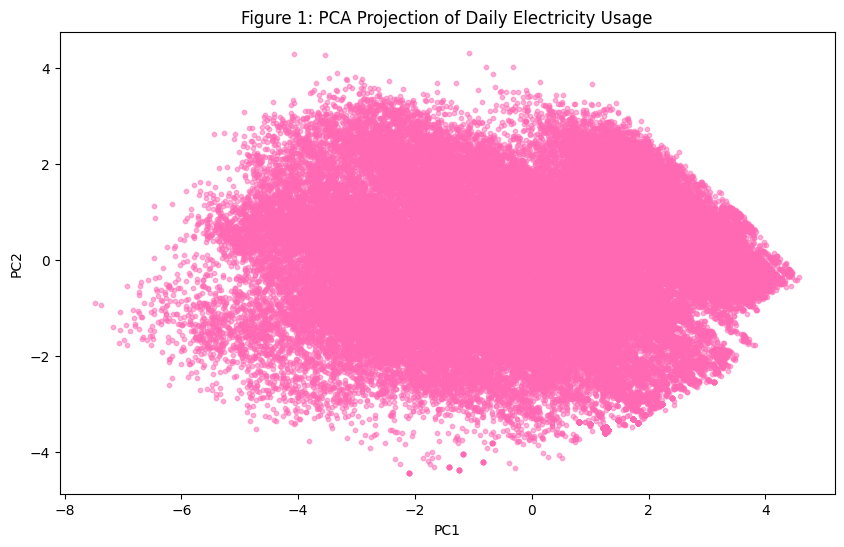

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(X_pca90[:, 0], X_pca90[:, 1], color = 'hotpink' , s=10, alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Figure 1: PCA Projection of Daily Electricity Usage")
plt.show()

In [ ]:
data = data_new.copy()

### Kmeans++

#### Elbow Method

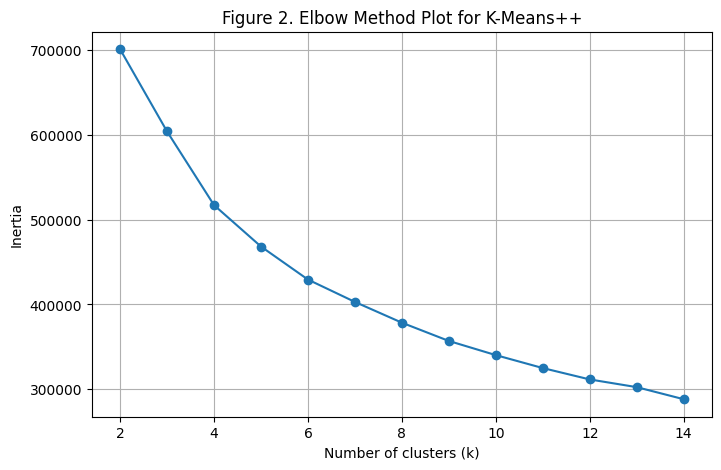

In [ ]:
K_range = range(2, 15)
inertias = []

for k in K_range:
    km = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=10,
        random_state=42
    )
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertias, marker="o")
plt.title("Figure 2. Elbow Method Plot for K-Means++")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, init="k-means++", random_state=67)
clusters = kmeans.fit_predict(X_pca90)
data_new["cluster_k4"] = clusters

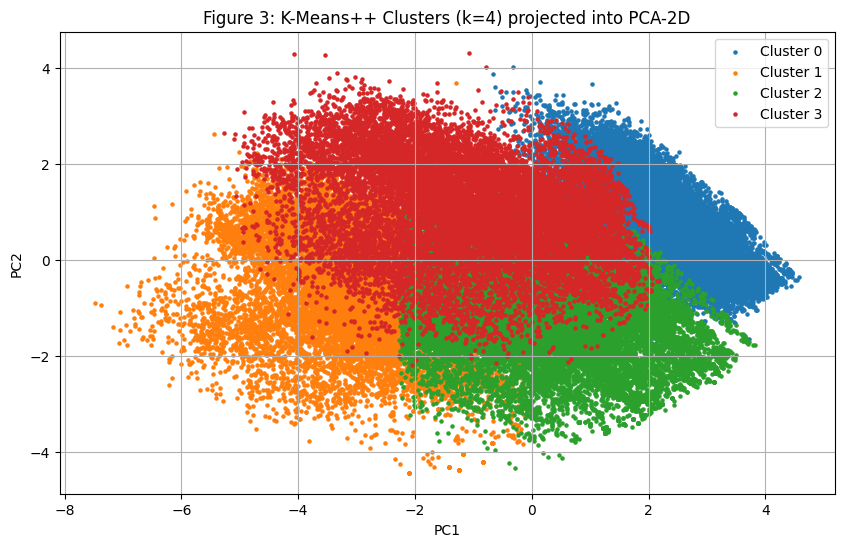

In [ ]:
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
for c in range(4):
    idx = clusters == c
    plt.scatter(X_pca2[idx, 0], X_pca2[idx, 1], s=5, label=f"Cluster {c}")

plt.title("Figure 3: K-Means++ Clusters (k=4) projected into PCA-2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
cluster_summary = data_new.groupby("cluster_k4").agg(
    avg_total_power = ("total_power", "mean"),
    avg_mean_power = ("mean_power", "mean"),
    avg_temp = ("mean_temp", "mean"),
    avg_humidity = ("mean_humidity", "mean"),
    avg_max_temp = ("max_temp", "mean"),
    avg_min_temp = ("min_temp", "mean"),
    count = ("cluster_k4", "count")
)

from IPython.display import HTML

title = "<h3>Figure 4: K-Means Cluster Summary Statistics</h3>"

html = cluster_summary.to_html(
    classes="table table-striped",
    float_format="{:.2f}".format,
    border=0
)

with open("cluster_summary.html", "w") as f:
    f.write("<h3>Figure 4: K-Means Cluster Summary Statistics</h3>" + html)

In [ ]:
season_dist = (
    data_new.groupby(["cluster_k4", "season"])
            .size()
            .unstack(fill_value=0)
)

print(season_dist)

season       fall  spring  summer  winter
cluster_k4                               
0               2    1118   20585       0
1            2408     182       8   10468
2           19027      11       0     202
3               0   15585       7       0


### DBSCAN

In [ ]:
eps_values = [0.2, 0.3, 0.4, 0.5, 0.7, 1.0]
min_samples_values = [10, 20, 30]

results = []

for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X_pca90)

        noise_pct = np.mean(labels == -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        results.append((eps, ms, n_clusters, noise_pct))

results_df = pd.DataFrame(results, columns=["eps", "min_samples", "n_clusters", "noise_pct"])
results_df["noise_pct"] = results_df["noise_pct"].astype(float)

# For example: sort by noise, then by number of clusters (descending)
print("\nSorted by noise % then clusters:")
print(results_df.sort_values(["noise_pct", "n_clusters"], ascending=[True, False]))


Sorted by noise % then clusters:
    eps  min_samples  n_clusters  noise_pct
15  1.0           10          10   0.002759
16  1.0           20           8   0.007816
17  1.0           30          10   0.014094
12  0.7           10          28   0.027398
13  0.7           20          19   0.063647
14  0.7           30          29   0.099450
9   0.5           10         113   0.107165
6   0.4           10         216   0.202850
10  0.5           20          83   0.206241
11  0.5           30          50   0.294312
7   0.4           20         122   0.343606
3   0.3           10         381   0.354884
8   0.4           30          80   0.446188
4   0.3           20         173   0.547347
0   0.2           10         530   0.637674
5   0.3           30          77   0.669037
1   0.2           20         139   0.838470
2   0.2           30          59   0.906958


In [ ]:
eps = 1
min_samples = 10

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
db_labels = dbscan.fit_predict(X_pca90)

data_new["cluster_db"] = db_labels
labels = db_labels
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print("DBSCAN Results:")
print(f"eps = {eps}, min_samples = {min_samples}")
print(f"Number of clusters found: {n_clusters}")
print(f"Number of noise points: {n_noise}")

cluster_sizes = data_new["cluster_db"].value_counts().sort_index()
print("\nCluster sizes:")
print(cluster_sizes)

DBSCAN Results:
eps = 1, min_samples = 10
Number of clusters found: 10
Number of noise points: 192

Cluster sizes:
cluster_db
-1      192
 0    15361
 1     6039
 2     7611
 3     3015
 4    14755
 5     5828
 6    12087
 7     4678
 8       16
 9       21
Name: count, dtype: int64


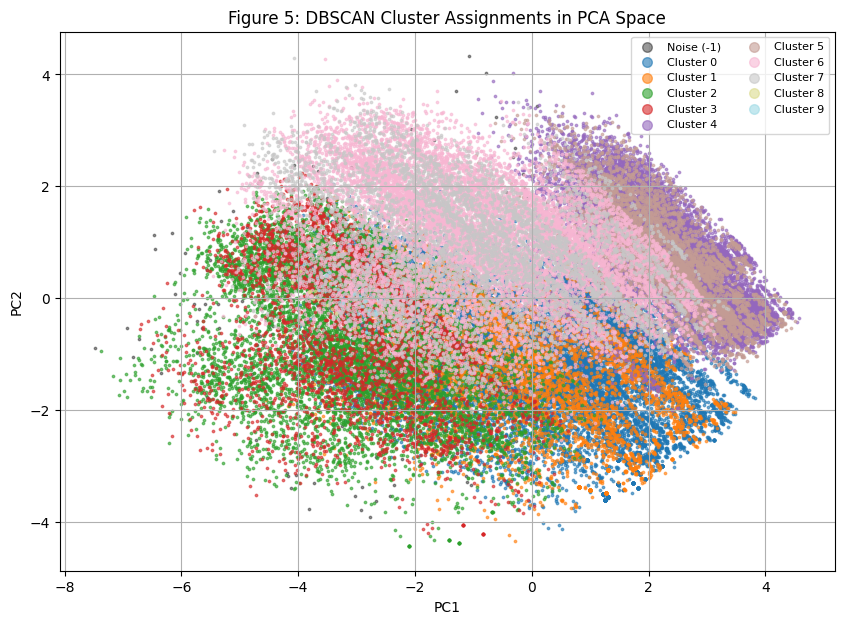

In [ ]:
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))

mask_noise = (db_labels == -1)
plt.scatter(
    X_pca2[mask_noise, 0], X_pca2[mask_noise, 1],
    s=3, c="black", alpha=0.4, label="Noise (-1)"
)

unique_clusters = sorted([c for c in set(db_labels) if c != -1])
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))

for c, color in zip(unique_clusters, colors):
    mask = (db_labels == c)
    plt.scatter(
        X_pca2[mask, 0], X_pca2[mask, 1],
        s=3, alpha=0.6, color=color, label=f"Cluster {c}"
    )

plt.title(f"Figure 5: DBSCAN Cluster Assignments in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(markerscale=4, ncol=2, fontsize=8)
plt.grid(True)
plt.show()


### GMM

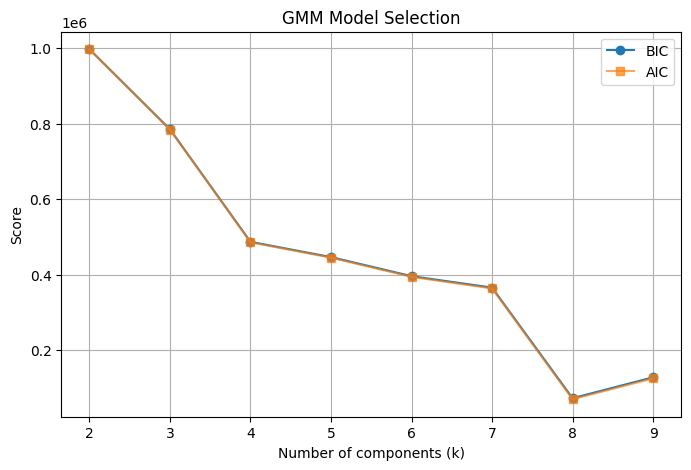

In [ ]:
ks = range(2, 10)
bics = []
aics = []

for k in ks:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",
        random_state=42,
        n_init=5
    )
    gmm.fit(X_pca90)
    bics.append(gmm.bic(X_pca90))
    aics.append(gmm.aic(X_pca90))

plt.figure(figsize=(8,5))
plt.plot(ks, bics, marker="o", label="BIC")
plt.plot(ks, aics, marker="s", label="AIC", alpha=0.7)
plt.xlabel("Number of components (k)")
plt.ylabel("Score")
plt.title("GMM Model Selection")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
best_k = 4

gmm = GaussianMixture(
    n_components=best_k,
    covariance_type="full",
    random_state=67,
    n_init=5
)
gmm_labels = gmm.fit_predict(X_pca90)

data_new["cluster_gmm"] = gmm_labels

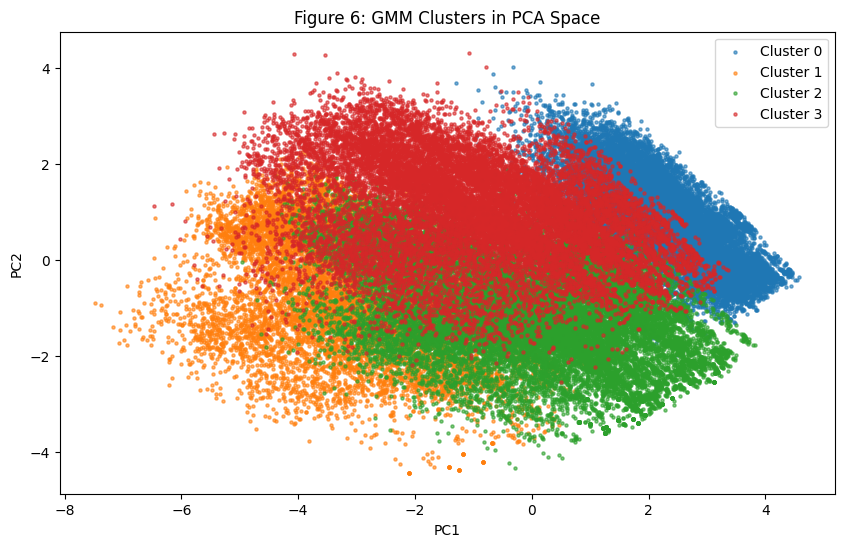

In [ ]:
plt.figure(figsize=(10,6))

for c in range(best_k):
    mask = (gmm_labels == c)
    plt.scatter(
        X_pca90[mask, 0],
        X_pca90[mask, 1],
        s=5, alpha=0.6,
        label=f"Cluster {c}"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"Figure 6: GMM Clusters in PCA Space")
plt.legend()
plt.show()

In [ ]:
gmm_summary = data_new.groupby("cluster_gmm").agg(
    avg_total_power=("total_power","mean"),
    avg_mean_power=("mean_power","mean"),
    avg_temp=("mean_temp","mean"),
    avg_humidity=("mean_humidity","mean"),
    count=("cluster_gmm","size")
)

print(gmm_summary)


title = "<h3>Figure 7: GMM Cluster Summary Statistics</h3>"

html = gmm_summary.to_html(
    classes="table table-striped",
    float_format="{:.2f}".format,
    border=0
)

with open("gmm_summary.html", "w") as f:
    f.write("<h3>Figure 7: GMM Cluster Summary Statistics</h3>" + html)

             avg_total_power  avg_mean_power   avg_temp  avg_humidity  count
cluster_gmm                                                                 
0                 341.033988        0.467726  70.045766      0.696885  20600
1                1151.699769        1.587890  33.208294      0.703439  10670
2                 561.112559        0.836136  52.405040      0.726944  21437
3                 833.363976        1.065250  50.416931      0.598886  16896


# T-SNE

Shape of t-SNE components: (69603, 2)


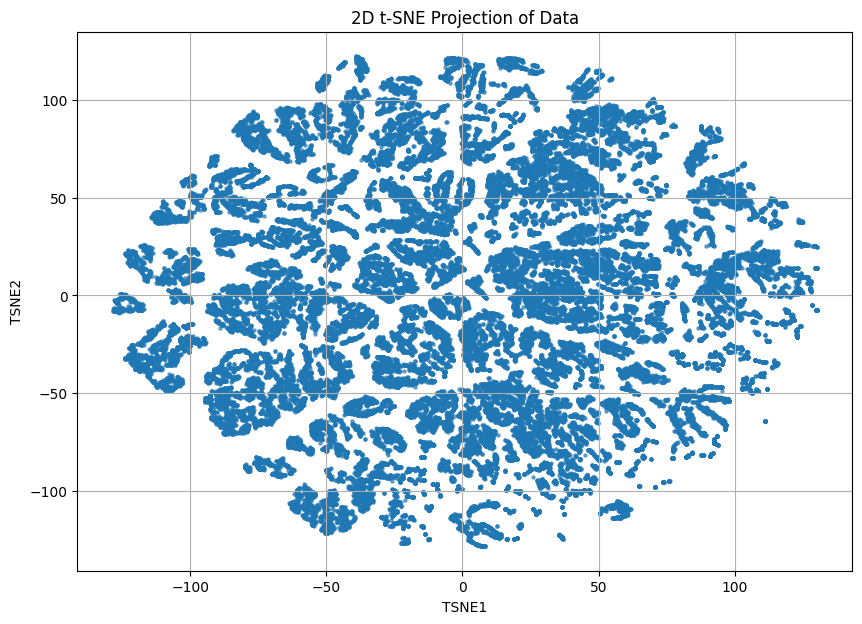

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

data_new["TSNE1"] = X_tsne[:, 0]
data_new["TSNE2"] = X_tsne[:, 1]

print("Shape of t-SNE components:", X_tsne.shape)
plt.figure(figsize=(10, 7))
plt.scatter(data_new["TSNE1"], data_new["TSNE2"], s=5, alpha=0.6)
plt.title("2D t-SNE Projection of Data")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.grid(True)
plt.show()

### K-Means

In [ ]:
kmeans = KMeans(n_clusters=4, init="k-means++", random_state=42)
clusters = kmeans.fit_predict(X_tsne)
data_new["cluster_k4"] = clusters

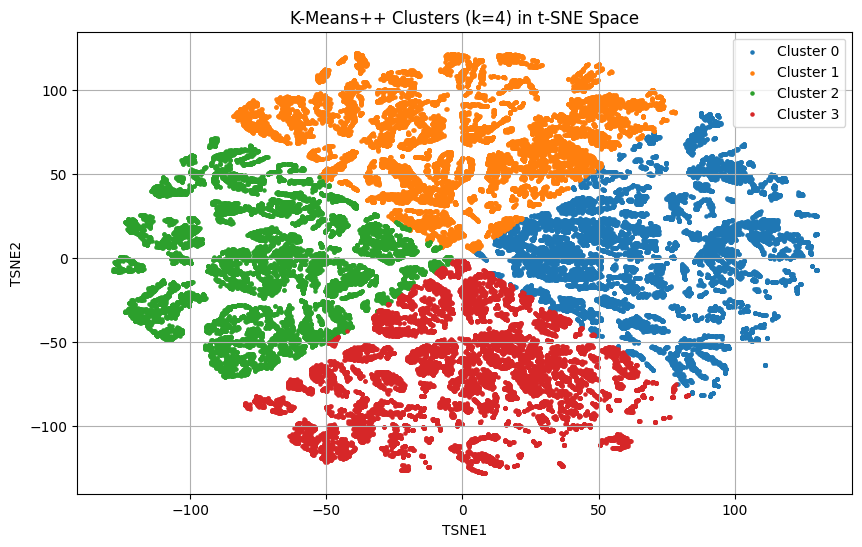

In [ ]:
plt.figure(figsize=(10, 6))

for c in range(4):
    idx = clusters == c
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], s=5, label=f"Cluster {c}")

plt.title("K-Means++ Clusters (k=4) in t-SNE Space")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.legend()
plt.grid(True)
plt.show()

### DBSCAN

In [ ]:
eps_values = [0.2, 0.3, 0.4, 0.5, 0.7, 1.0]
min_samples_values = [10, 20, 30]

results = []

for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X_scaled)

        noise_pct = np.mean(labels == -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        results.append((eps, ms, n_clusters, noise_pct))

results

[(0.2, 10, 269, np.float64(0.9114405988247632)),
 (0.2, 20, 76, np.float64(0.9632630777409019)),
 (0.2, 30, 28, np.float64(0.9837938019912935)),
 (0.3, 10, 326, np.float64(0.8284700372110397)),
 (0.3, 20, 113, np.float64(0.9029783199000043)),
 (0.3, 30, 45, np.float64(0.9358792006091692)),
 (0.4, 10, 363, np.float64(0.6563366521557978)),
 (0.4, 20, 120, np.float64(0.7952674453687341)),
 (0.4, 30, 56, np.float64(0.8572331652371306)),
 (0.5, 10, 345, np.float64(0.45551197505854635)),
 (0.5, 20, 128, np.float64(0.6305619010674828)),
 (0.5, 30, 56, np.float64(0.7190063646681896)),
 (0.7, 10, 143, np.float64(0.1885838254098243)),
 (0.7, 20, 101, np.float64(0.3060643937761303)),
 (0.7, 30, 61, np.float64(0.3965921009151904)),
 (1.0, 10, 30, np.float64(0.03412209243854432)),
 (1.0, 20, 21, np.float64(0.07039926439952301)),
 (1.0, 30, 25, np.float64(0.10026866658046349))]

In [ ]:
eps = 0.4
min_samples = 30

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
db_labels = dbscan.fit_predict(X_tsne)

data_new["cluster_db"] = db_labels
labels = db_labels
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print("DBSCAN Results:")
print(f"eps = {eps}, min_samples = {min_samples}")
print(f"Number of clusters found: {n_clusters}")
print(f"Number of noise points: {n_noise}")

cluster_sizes = data_new["cluster_db"].value_counts().sort_index()
print("\nCluster sizes:")
print(cluster_sizes)

DBSCAN Results:
eps = 0.4, min_samples = 30
Number of clusters found: 17
Number of noise points: 69063

Cluster sizes:
cluster_db
-1     69063
 0        30
 1        30
 2        30
 3        32
 4        33
 5        34
 6        33
 7        31
 8        32
 9        31
 10       31
 11       31
 12       33
 13       33
 14       32
 15       33
 16       31
Name: count, dtype: int64


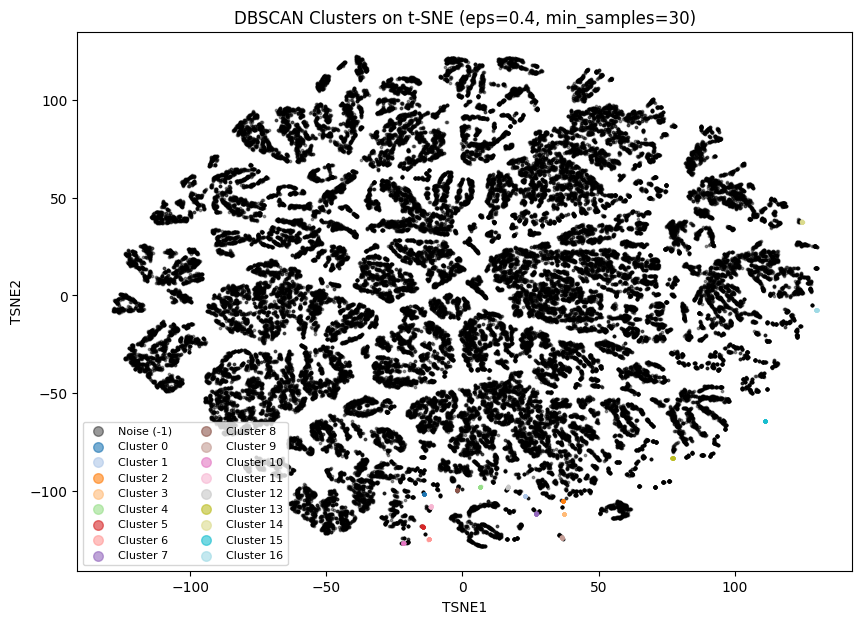

In [ ]:
plt.figure(figsize=(10, 7))

mask_noise = (labels == -1)
plt.scatter(
    X_tsne[mask_noise, 0],
    X_tsne[mask_noise, 1],
    s=3,
    c="black",
    alpha=0.4,
    label="Noise (-1)"
)

unique_clusters = sorted([c for c in set(labels) if c != -1])
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))

for c, color in zip(unique_clusters, colors):
    mask = (labels == c)
    plt.scatter(
        X_tsne[mask, 0],
        X_tsne[mask, 1],
        s=3,
        alpha=0.6,
        color=color,
        label=f"Cluster {c}"
    )

plt.title(f"DBSCAN Clusters on t-SNE (eps={eps}, min_samples={min_samples})")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.legend(markerscale=4, ncol=2, fontsize=8)
plt.show()

### GMM

In [ ]:
best_k = 5

gmm = GaussianMixture(
    n_components=best_k,
    covariance_type="full",
    random_state=67,
    n_init=5
)
gmm_labels = gmm.fit_predict(X_tsne)

data_new["cluster_gmm"] = gmm_labels

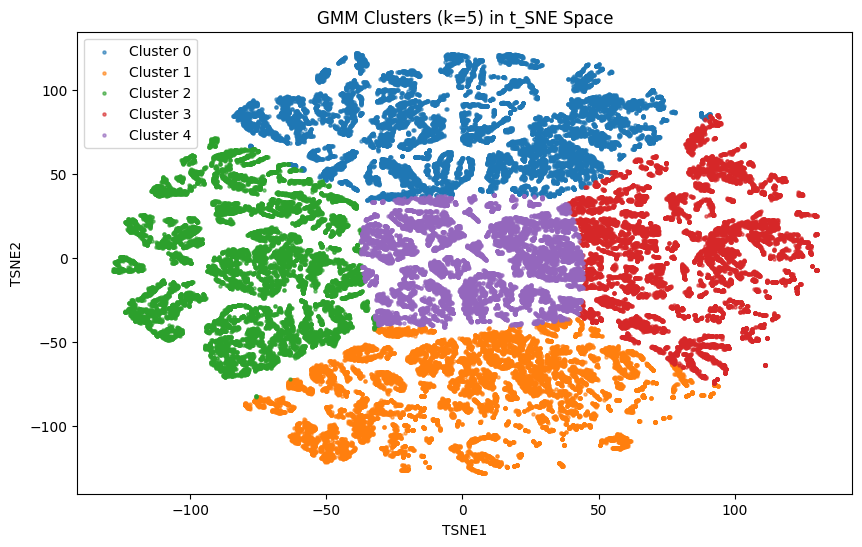

In [ ]:
plt.figure(figsize=(10,6))

for c in range(best_k):
    mask = (gmm_labels == c)
    plt.scatter(
        X_tsne[mask, 0],
        X_tsne[mask, 1],
        s=5, alpha=0.6,
        label=f"Cluster {c}"
    )

plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.title(f"GMM Clusters (k={best_k}) in t_SNE Space")
plt.legend()
plt.show()

# Association Rule Mining

In [ ]:
cols_to_bin = ["total_power", "mean_power", "mean_temp", "mean_humidity"]

data_arm = data.copy()
for col in cols_to_bin:
    data_arm[f"{col}_bin"] = pd.qcut(
        data_arm[col],
        q=3,
        labels=["low", "med", "high"],
        duplicates="drop"
    )

data_arm["week_type"] = data_arm["is_weekend"].map({0: "weekday", 1: "weekend"})
arm_cols = [f"{col}_bin" for col in cols_to_bin] + ["season", "week_type"]
arm_df = data_arm[arm_cols].astype(str)
arm_df.head()


,total_power_bin,mean_power_bin,mean_temp_bin,mean_humidity_bin,season,week_type
5,low,low,low,low,fall,weekday
7,low,low,med,high,fall,weekday
8,low,low,med,high,fall,weekday
9,low,low,med,high,fall,weekday
10,low,low,med,med,fall,weekend


In [ ]:
transactions = pd.get_dummies(arm_df, prefix=arm_cols)
transactions = transactions.astype(bool)

print(transactions.shape)
transactions.head()

(69603, 18)


,total_power_bin_high,total_power_bin_low,total_power_bin_med,mean_power_bin_high,mean_power_bin_low,mean_power_bin_med,mean_temp_bin_high,mean_temp_bin_low,mean_temp_bin_med,mean_humidity_bin_high,mean_humidity_bin_low,mean_humidity_bin_med,season_fall,season_spring,season_summer,season_winter,week_type_weekday,week_type_weekend
5,False,True,False,False,True,False,False,True,False,False,True,False,True,False,False,False,True,False
7,False,True,False,False,True,False,False,False,True,True,False,False,True,False,False,False,True,False
8,False,True,False,False,True,False,False,False,True,True,False,False,True,False,False,False,True,False
9,False,True,False,False,True,False,False,False,True,True,False,False,True,False,False,False,True,False
10,False,True,False,False,True,False,False,False,True,False,False,True,True,False,False,False,False,True


### Apriori

In [ ]:
min_support = 0.05

frequent_itemsets_ap = apriori(
    transactions,
    min_support=min_support,
    use_colnames=True
).sort_values("support", ascending=False)

print("Apriori frequent itemsets (top 10):")
print(frequent_itemsets_ap.head(10))

Apriori frequent itemsets (top 10):
     support                 itemsets
16  0.716435      (week_type_weekday)
11  0.336121  (mean_humidity_bin_med)
7   0.334483      (mean_temp_bin_low)
10  0.333922  (mean_humidity_bin_low)
5   0.333333     (mean_power_bin_med)
4   0.333333     (mean_power_bin_low)
1   0.333333    (total_power_bin_low)
3   0.333333    (mean_power_bin_high)
0   0.333333   (total_power_bin_high)
2   0.333333    (total_power_bin_med)


In [ ]:
rules_ap = association_rules(
    frequent_itemsets_ap,
    metric="confidence",
    min_threshold=0.6
)

rules_ap = rules_ap.sort_values("lift", ascending=False)
rules_ap[["antecedents", "consequents", "support", "confidence", "lift"]].head(15)

,antecedents,consequents,support,confidence,lift
172,"(total_power_bin_med, mean_temp_bin_high)","(mean_power_bin_low, season_summer)",0.065830,0.678312,4.004799
171,"(total_power_bin_med, season_summer)","(mean_temp_bin_high, mean_power_bin_low)",0.065830,0.753371,3.949153
214,"(season_winter, total_power_bin_med)","(mean_power_bin_high, mean_temp_bin_low)",0.056794,0.863666,3.521603
221,"(season_winter, total_power_bin_high)","(mean_power_bin_high, mean_temp_bin_low)",0.055975,0.746646,3.044453
48,(season_winter),"(mean_power_bin_high, mean_temp_bin_low)",0.112768,0.735614,2.999469
211,"(season_winter, mean_humidity_bin_low)",(mean_temp_bin_low),0.056822,1.000000,2.989691
91,"(mean_temp_bin_med, mean_humidity_bin_low)",(season_spring),0.086993,0.725237,2.987609
117,"(season_winter, week_type_weekday)","(mean_power_bin_high, mean_temp_bin_low)",0.079451,0.725722,2.959134
116,"(season_winter, mean_power_bin_high)","(week_type_weekday, mean_temp_bin_low)",0.079451,0.663706,2.845279
212,"(season_winter, total_power_bin_med, mean_powe...",(mean_temp_bin_low),0.056794,0.950012,2.840243


### FP-Growth

In [ ]:
frequent_itemsets_fp = fpgrowth(
    transactions,
    min_support=min_support,
    use_colnames=True
).sort_values("support", ascending=False)

rules_fp = association_rules(
    frequent_itemsets_fp,
    metric="confidence",
    min_threshold=0.6
).sort_values("lift", ascending=False)

rules_fp[["antecedents", "consequents", "support", "confidence", "lift"]].head(15)

,antecedents,consequents,support,confidence,lift
172,"(total_power_bin_med, mean_temp_bin_high)","(mean_power_bin_low, season_summer)",0.065830,0.678312,4.004799
171,"(total_power_bin_med, season_summer)","(mean_temp_bin_high, mean_power_bin_low)",0.065830,0.753371,3.949153
214,"(season_winter, total_power_bin_med)","(mean_power_bin_high, mean_temp_bin_low)",0.056794,0.863666,3.521603
221,"(season_winter, total_power_bin_high)","(mean_power_bin_high, mean_temp_bin_low)",0.055975,0.746646,3.044453
48,(season_winter),"(mean_power_bin_high, mean_temp_bin_low)",0.112768,0.735614,2.999469
211,"(season_winter, mean_humidity_bin_low)",(mean_temp_bin_low),0.056822,1.000000,2.989691
91,"(mean_temp_bin_med, mean_humidity_bin_low)",(season_spring),0.086993,0.725237,2.987609
117,"(season_winter, week_type_weekday)","(mean_power_bin_high, mean_temp_bin_low)",0.079451,0.725722,2.959134
116,"(season_winter, mean_power_bin_high)","(week_type_weekday, mean_temp_bin_low)",0.079451,0.663706,2.845279
212,"(season_winter, total_power_bin_med, mean_powe...",(mean_temp_bin_low),0.056794,0.950012,2.840243


### Plots

chatgbt helped with this plot

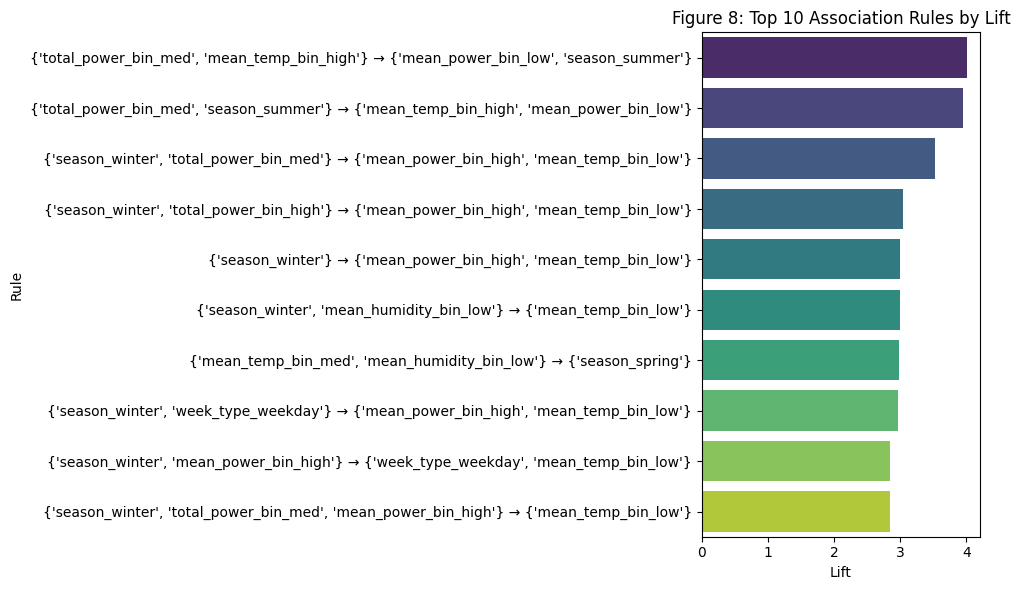

In [ ]:
top_rules = rules_fp.sort_values("lift", ascending=False).head(10)

top_rules["rule_text"] = top_rules.apply(
    lambda row: f"{set(row['antecedents'])} → {set(row['consequents'])}", axis=1
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_rules,
    x="lift",
    y="rule_text",
    palette="viridis"
)

plt.title("Figure 8: Top 10 Association Rules by Lift")
plt.xlabel("Lift")
plt.ylabel("Rule")
plt.tight_layout()
plt.show()
